# Generating Correct Names
using real data collected from student name - [dataset url](https://forums.madrsa-online.com/threads/3264/)
#### Rules for data proivded (it has males and females separated not applicable for my collected data)
- 3 words
- First word can be male/female
- Second and third words must be males

In [1]:
from typing import List
import pandas as pd
import random
import string

from collections import Counter
from tqdm import tqdm

random.seed(23)

In [2]:
ds_name = 'both_generated_using_correct_names_40k_better_repeatedfunction'
ds_size = 40_000

## Generate Correct names

In [3]:
names_df = pd.read_csv("data/all_names.txt", names=['name'])
print(names_df.shape)
names_df.sample(10)

(3729, 1)


,name
1838,ياسر
1823,العتبانى
3108,مندور
3373,قاسم
3116,شيماء
639,عبدالعليم
655,هاتم
257,عيناء
1101,جنيدى
2855,لبيب


In [4]:
correct_names = names_df['name'].tolist()

In [5]:
def generate_fullnames(male_names: List[str], female_list: List[str] = None, num_names = 1000) -> List[str]:
    """
    Generates full names where second and third names must always be males.
    """
    names = []

    for _ in range(num_names):
        # males
        names.append(" ".join(random.sample(male_names, 3)))
        # females
        if female_list:
            names.append(random.sample(female_names, 1)[0] + " " + " ".join(random.sample(male_names, 2)))
    
    return names

In [6]:
names = generate_fullnames(correct_names, num_names=ds_size//2)
print(f"Number of names generated: {len(names)}")
names[:3]

Number of names generated: 20000


['حمايه تيسير لاوند', 'سعداحمد ابراهبم برى', 'مكة ولاء كريمه']

In [7]:
pd.DataFrame(names, columns=["Name"]).to_csv("data/full_correct_names.csv", index=None)

In [8]:
temp_df = pd.read_csv("data/full_correct_names.csv")
temp_df.head()

,Name
0,حمايه تيسير لاوند
1,سعداحمد ابراهبم برى
2,مكة ولاء كريمه
3,زايد ثراء سحاق
4,الاسمر الشندى العوضى


### Stats about our names 

(Max, Min, Mean)


(3, 3, 3.0)

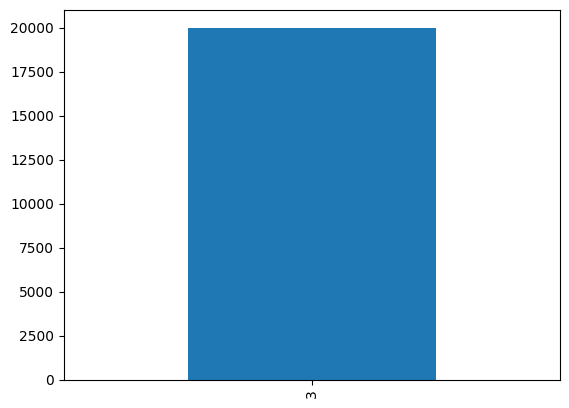

In [9]:
temp_df['Name'].str.split().map(len).value_counts().plot.bar()
print("(Max, Min, Mean)")
temp_df['Name'].str.split().map(len).max(), temp_df['Name'].str.split().map(len).min(), temp_df['Name'].str.split().map(len).mean()

# Generating Bad Names (over engineered)
generate individual full names:
- total garbage
  - we can randomly shuffle the correct names
- mistype names
  - repeat random characters
  - remove random characters
- other correct words but not names
- mix of all of above
- mix bad and good names

### Helper functions 

### Generate names with repeated and or mistyped characters between 1, 2

In [10]:
def mistype_characters(name: str, num_repeats: int) -> str:
    """
    Repeat random characters for a num of repeats, randomly turned off(to reduce the number of repeats) so words are not recognizably long.
    """
    new_name: str = ""
    for idx, ch in enumerate(name):
        new_name += ch * random.randint(0, num_repeats)
    
    return new_name

In [11]:
mistype_characters("مريم", 2)

'مرييم'

In [12]:
mistyped_names = []
for name in names_df.iloc[:, 0].values:
    mistyped_names.append(mistype_characters(name, 2))
    
mistyped_names[:10]

['ززيير',
 'صصففوح',
 'عللا',
 'بر',
 'زاا',
 'ننررةة',
 'ععببددللنااعع',
 'خخللو',
 'مريم',
 'اابب']

### Get some random but correct words from the internet

In [13]:
df = pd.read_csv("data/ar_reviews_100k.tsv", sep="\t")
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [14]:
word_counter = Counter()

for sent in tqdm(df.iloc[:, 1], total=df.shape[0]):
    # remove Punctuation first
    sent = sent.translate(str.maketrans('', '', string.punctuation))
    word_counter.update(sent.split())

print(f"Number of words: {len(word_counter)}")
some_common_words = word_counter.most_common()[10_000: 15_000]
some_common_words = [i[0] for i in some_common_words]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99999/99999 [00:03<00:00, 25394.32it/s]

Number of words: 351992


### Total Garabage

In [15]:
garbage_names = []

for name in names_df.iloc[:, 0].values:
    name = list(name)
    random.shuffle(name)
    garbage_names.append("".join(name))
    
garbage_names[:10]

['رهزي',
 'فوحص',
 'عيلاا',
 'رجوب',
 'ازهى',
 'ورنة',
 'عدانفبعال',
 'لوخد',
 'ممري',
 'عارب']

## Generating Bad Names
- [x] total garbage
- [x] mistype
- [x] correct words but not names
- [x] mix bad names
- [x] mix good and bad names
    - 1 or 2 good names

In [16]:
def generate_mix(bad_names: List[str], good_names: List[str], num_names: int = 500) -> List[str]:
    """
    Generate 3-words names that have 1 or 2 correct names in it.
    """
    
    names = []
    for _ in range(num_names):
        # pick 1 or 2 good names
        num_good = random.randint(1, 2)
        num_bad = 3 - num_good

        name_words = []
        name_words.extend(random.sample(good_names, num_good)) # good names
        name_words.extend(random.sample(bad_names, num_bad)) # bad names
        random.shuffle(name_words)
        names.append(" ".join(name_words))
        
    return names

In [19]:
# garbage
n = ds_size//2//5

bad_names = []
bad_names.extend(generate_fullnames(garbage_names, num_names=n))

# mistyped
bad_names.extend(generate_fullnames(mistyped_names, num_names=n))

# correct but not names
bad_names.extend(generate_fullnames(some_common_words, num_names=n))

# mix bad names
bad_names.extend(generate_fullnames(garbage_names+mistyped_names+some_common_words, num_names=n))

# mix good and bad names
bad_names.extend(generate_mix(garbage_names+mistyped_names+some_common_words, correct_names, num_names=n))

print(f"Number of bad names: {len(bad_names)}")

Number of bad names: 20000


In [20]:
pd.DataFrame(bad_names, columns=["Name"]).to_csv("data/full_bad_names.csv", index=None)

In [21]:
temp_df = pd.read_csv("data/full_bad_names.csv")
temp_df.sample(5)

,Name
14193,بحصى دالل نحيسه
19965,شوف عمرمنصور جزر
18974,اابهسىنلو مصلحى حنفى
5328,ووههدىى ييسسميننه اا
447,ادهسع شباع مىعر


# Making the Dataset

In [22]:
df_correct = pd.read_csv("data/full_correct_names.csv")
df_incorrect = pd.read_csv("data/full_bad_names.csv")

In [23]:
full_df = df_correct.copy()
full_df['class'] = 1
full_df = pd.concat([full_df, df_incorrect], ignore_index=True)
full_df.fillna(0, inplace=True)
full_df

,Name,class
0,حمايه تيسير لاوند,1.0
1,سعداحمد ابراهبم برى,1.0
2,مكة ولاء كريمه,1.0
3,زايد ثراء سحاق,1.0
4,الاسمر الشندى العوضى,1.0
...,...,...
39995,حامد قطار عزيزة,0.0
39996,ععددوو خليفة اسماء,0.0
39997,العسوى رحاب وه,0.0
39998,خادم بشاره لب,0.0


In [24]:
full_df.to_csv(f"data/{ds_name}.csv", index=False)
temp_df = pd.read_csv(f"data/{ds_name}.csv")
print(temp_df.shape)
temp_df.sample(5)

(40000, 2)


,Name,class
32958,حزم الاختلاط لسسعع,0.0
14925,غيداء سعاد مشيره,1.0
10017,باسل معاز السلاوى,1.0
12709,عبدالعالم اسمى امال,1.0
38670,وروعة راوية جوهرة,0.0
